# **(ADD HERE THE NOTEBOOK NAME)**

## Objectives

* Using data from Kaggle, answer Business Requirement 1.


## Inputs

Following sets:

* Train

* Validation

* Test



## Outputs

Creating:
* The shapes of images
* Images per label plotted according to their variability and mean
* Plots illustrating the differences between healthy and mildewed leaves






In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/project5/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
work_dir = os.getcwd()
work_dir

'/workspaces/project5'

In [4]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns; sns.set_style("whitegrid")


In [5]:
my_data_dir = 'inputs/datasets/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'
my_data_dir

'inputs/datasets/cherry-leaves'

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available, please create a new version.')
  pass
else:
  os.makedirs(name=file_path)


# version = 'v1'
# file_path = f'outputs/{version}'

# if not os.path.exists(f'{work_dir}/outputs/{version}'):
#     os.makedirs(f'{work_dir}/outputs/{version}')
# else:
#     print('Old version is already available, please create a new version.')

# Analyzing image data and visualizing it

Label for the images are ['powdery_mildew', 'healthy']


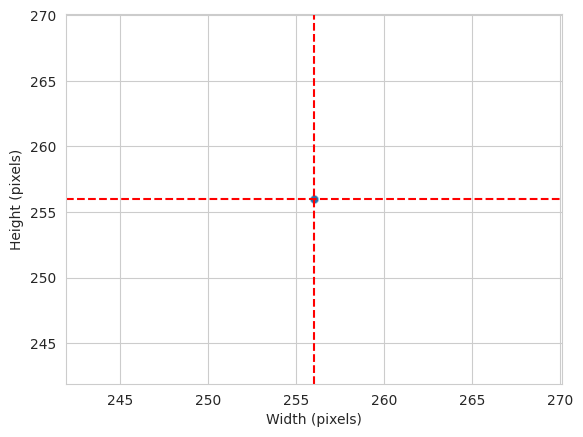

Width average: 256 
Height average: 256


In [7]:
# labels = os.listdir(train_path)
# print('Label for the images are',labels)

# dim1, dim2 = [], []
# for label in labels:
#   # iterate over each file of both folders and get height and width of the image
#   # and append it to the respective array (dim1=height, dim2=width) 
#   for image_filename in os.listdir(train_path + '/'+ label):
#     img = imread(train_path + '/' + label + '/'+ image_filename)
#     d1, d2, colors = img.shape # the shape give as an array with height, width and colors
#     dim1.append(d1) # image height
#     dim2.append(d2) # image width
# # Using matplotlib.pyplot to create the figure and the axes of the plot
# # Using seaborn to give the values to x and y
# fig, axes = plt.subplots()
# sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
# axes.set_xlabel("Width (pixels)")
# axes.set_ylabel("Height (pixels)")
# dim1_mean = int(np.array(dim1).mean())
# dim2_mean = int(np.array(dim2).mean())
# axes.axvline(x=dim1_mean,color='r', linestyle='--')
# axes.axhline(y=dim2_mean,color='r', linestyle='--')
# plt.show()
# print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")



labels = os.listdir(train_path)
print('Label for the images are',labels)

dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_path + '/'+ label):
    img = imread(train_path + '/' + label + '/'+ image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
plt.axvline(x=dim1_mean,color='r', linestyle='--')
plt.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")


In [8]:
image_shape = (64,64,3)
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

In [9]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50,50), n_images_per_label = 20):
  """ We generate two arrays, one with images and the other one with labels, so 
      we can analyze the processed images """
      
  X, y = np.array([], dtype='int'), np.array([], dtype='object')
  labels = os.listdir(my_data_dir)

  for label in labels:
    counter = 0
    for image_filename in os.listdir(my_data_dir + '/' + label):
      # n_images_per_label: we set a limit, since it may take too much time
      if counter < n_images_per_label:
        img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
        if image.img_to_array(img).max() > 1: 
          img_resized = image.img_to_array(img) / 255
        else: 
          img_resized = image.img_to_array(img)
        
        X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y
  
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

# from tensorflow.keras.preprocessing import image

# def load_image_as_array(my_data_dir, new_size=(50,50), n_images_per_label=20):
#     X, y = [], []
#     for label in os.listdir(my_data_dir):
#         for image_filename in os.listdir(f"{my_data_dir}/{label}")[:n_images_per_label]:
#             img = image.load_img(f"{my_data_dir}/{label}/{image_filename}", target_size=new_size)
#             img_resized = image.img_to_array(img) / 255.0
#             X.append(img_resized)
#             y.append(label)
#     return np.array(X), np.array(y)


(60, 64, 64, 3) (60,)
